In [1]:
# big test of least squares
# 1. import the b0 map
# import b0map as an object
import numpy as np  
import b0
b0map = b0.b0()
filename_to_import_csv_data_from = r'./\data\240619\Thursday_ball_R120_12pts_bvals_shifted.csv'
b0map.import_from_csv(filename_to_import_csv_data_from)
b0map.transfer_coordinates_of_the_path_from_cosi_to_magnet()


# change coordinates to magnet



No path object given on construction of b0 object.
 b0 instance initialized without path.
importing b0 object from csv file./\data\240619\Thursday_ball_R120_12pts_bvals_shifted.csv
No path object given on construction of b0 object.
 b0 instance initialized without path.
warning. path file  /home/cosi/cosi-measure/Software/COSI2/data/240719/Thursday_ball_R120_12pts,,,,,,
 not used. path data taken from csv!
importing path from a csv file
ROTATING THE PATH NOW!
path center set to:  [-1.49212153e-03  2.23818229e-03 -3.57200575e+00]
ROTATING THE MAGNET NOW!
warning! euler angles of the magnet changed!
len(path.r)= 11487
len(b0Data)= 11487
-111.4292539392357  < x <  111.4307460607643
-116.42575607208154  < y <  115.00424392791848
-115.00349786715418  < z <  107.85650213284583
path step size:  8.569999999999936 8.569999999999936 8.569999999999936
xPts:  [-111.42925394 -102.85925394  -94.28925394  -85.71925394  -77.14925394
  -68.57925394  -60.00925394  -51.43925394  -42.86925394  -34.2992539

In [2]:
print(np.nanmin(b0map.b0Data[:,:,:,0]))
print(np.nanmax(b0map.b0Data[:,:,:,0]))

# spherical decomposition
diameter_of_sphere = b0map.path.radius*2
order = 17
resolution_of_sph_decomp = 10
print(diameter_of_sphere)
b0map.fitSphericalHarmonics(maxorder=order,dsv=diameter_of_sphere,resol=resolution_of_sph_decomp)

resolution_of_sph_fit=8
print('interpolating field with sph order %d, resol %.0f mm'%(order,resolution_of_sph_fit))

b0map.interpolateField(resol=resolution_of_sph_fit,dsv=diameter_of_sphere)


-47.809
-47.394
239.91103289828555
(27, 28, 27)
Mean field strength in 23 cm sphere: -47.55 mT
Inhomogeneity in 23 cm sphere: -5783 ppm
Inhomogeneity of fit: 5679 ppm
Error: -332 ppm
saved numpy array as ./data/tmp/SpHData.npy
interpolating field with sph order 17, resol 8 mm
sph coefficients loaded
making a fine coordinate grid
Inhomogeneity of fit: 5384 ppm
saved numpy array as ./data/tmp/B0_interpolated.npy


In [3]:
print('now we have an interpolated field.')
print(np.shape(b0map.interpolatedField))
print('on a coordinate grid')
print(np.shape(b0map.coord_grid_fine))



now we have an interpolated field.
(30, 30, 30)
on a coordinate grid
(3, 30, 30, 30)


In [4]:
# shim magnets positinoing

mu                  = 1e-7

magSizeOuter        = 6*1e-3        #size of shim magnets
bRem                = 1.35 # [T]      #remanence field of shim magnets

#shim tray configuration
def ringposFromTrayNr(trays_ocp):
    trayslitspacing = 9e-3 # [m]
    coordinates = []
    for tray_pos in trays_ocp:
        coordinate = trayslitspacing*tray_pos-4.5e-3 if tray_pos>0 else trayslitspacing*tray_pos+4.5e-3
        coordinates.append(coordinate)
    return coordinates


shimRadius          = 276*1e-3#276*1e-3 <- was set by Tom!      # radius on which the shim magnets are placed

trays_occupied = [-7,-5,1,14] #[-18,-5,1,12] <- 27mm best  [-7,-5,1,14] 997
ringPositions       = ringposFromTrayNr(trays_occupied)#[-121.5*1e-3, -40.5*1e-3, 31.5*1e-3, 121.5*1e-3]#np.linspace(-ringspacingouter,ringspacingouter,4)#np.linspace(-0.1755,0.1755,4)          #np.linspace(-0.2295, .2295, 4) #Z positions to place shin rubgs
print(np.array(ringPositions)*1e3)


[-58.5 -40.5   4.5 121.5]


In [5]:

magsPerSegment      = 7             # number of magnets peer shim tray segment
anglePerSegment     = 19.25 #the angular distance in degrees between the furthest magnets in a shim tray (span of magnets in shim tray)
numSegments         = 12 #corresponds to the number of shim trays


segmentAngles       = np.linspace(0,360, numSegments, endpoint = False)

magAngles           = np.linspace(-anglePerSegment/2, anglePerSegment/2, magsPerSegment) 

print('let us position some magnets on a circumference of a R=%.0f mm YZ circle with X=0'%(shimRadius*1000))

positions = []
for ringPosition in ringPositions:
    for segmentAngle in segmentAngles:
        for magAngle in magAngles:
            # the most important line is this. Our bore is along X, so we create an array of positions along X, not along Z!
            #positions.append((shimRadius*np.cos((segmentAngle+magAngle)*np.pi/180), shimRadius*np.sin((segmentAngle+magAngle)*np.pi/180), ringPosition))
            positions.append((ringPosition,shimRadius*np.cos((segmentAngle+magAngle)*np.pi/180), shimRadius*np.sin((segmentAngle+magAngle)*np.pi/180)))

        # check if rings are in the right plane
        #print(positions) 
# #!TEMP!!!
# pos = [0,0,25e-3]
# positions = []
# positions.append(pos)
# print(len(positions))


let us position some magnets on a circumference of a R=276 mm YZ circle with X=0


magnet created, dipole points to  [0. 1. 0.]
[0.00000000e+00 2.32047907e-08 0.00000000e+00]
HALLO?!
(-0.0585, 0.27211479674710887, -0.04614691096140277)
x vector length in single magnet simulation:  30
calculating field of one shim magnet at  -0.0585 0.27211479674710887 -0.04614691096140277
magnet created, dipole points to  [0. 1. 0.]
[0.00000000e+00 2.32047907e-08 0.00000000e+00]
HALLO?!
(-0.0585, 0.2742709847847707, -0.030845208788272026)
x vector length in single magnet simulation:  30
calculating field of one shim magnet at  -0.0585 0.2742709847847707 -0.030845208788272026
magnet created, dipole points to  [0. 1. 0.]
[0.00000000e+00 2.32047907e-08 0.00000000e+00]
HALLO?!
(-0.0585, 0.27556740718070843, -0.015446815196073495)
x vector length in single magnet simulation:  30
calculating field of one shim magnet at  -0.0585 0.27556740718070843 -0.015446815196073495
magnet created, dipole points to  [0. 1. 0.]
[0.00000000e+00 2.32047907e-08 0.00000000e+00]
HALLO?!
(-0.0585, 0.276, 0.0)


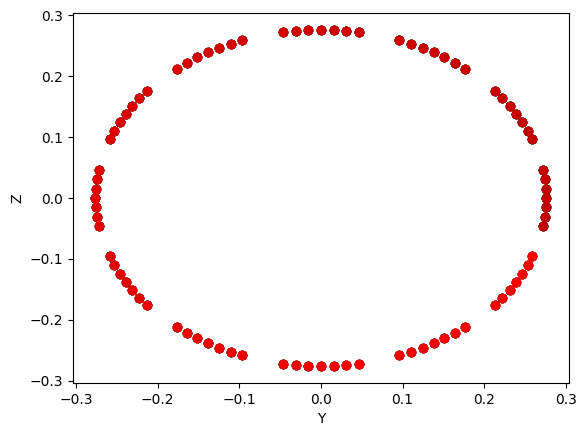

In [6]:

import matplotlib.pyplot as plt
for idx,position in enumerate(positions):

    plt.scatter(position[1],position[2],color = [idx/len(positions),0,0])

plt.xlabel('Y')
plt.ylabel('Z')


initialField = b0map.interpolatedField
numMags = len(positions)
coordinate_grid = b0map.coord_grid_fine



magnetFields = np.zeros((np.shape(initialField)+(3,numMags)), dtype = np.float32)
magnetFields_fair = np.zeros((np.shape(initialField)+(3,numMags)), dtype = np.float32)


def magnetization(bRem, dimensions, shape = 'cube', evalDistance = 1):
    #Use the analytical expression for the z component of a cube magnet to estimate
    #dipole momentstrength for correct scaling. Dipole approximation only valid 
    #far-ish away from magnet, comparison made at 1 meter distance.
    if shape == 'cube':
        b_analytic = (bRem/np.pi) *(np.arctan2(dimensions**2, 2*evalDistance *np.sqrt(4*(evalDistance**2) + 2*(dimensions**2)))-\
                        np.arctan2(dimensions**2, 2*(dimensions + evalDistance)*\
                                   np.sqrt(4*((dimensions+evalDistance)**2)+2*(dimensions**2))))
    
        dip_mom = b_analytic * (dimensions/2 + evalDistance)**3 /(2*mu) #strength of the dipole moment
    
    return dip_mom

from utils import shimming_magnet

shimming_magnets = []

DSV = b0map.path.radius*2

dip_mom = magnetization(bRem=bRem,dimensions=magSizeOuter)
dip_vec = mu*np.array([0,dip_mom,0]) #initially along y

for idx1, position in enumerate(positions):
    magnet = shimming_magnet.shimming_magnet(position=position,rotation_yz=0)
    magnet.render_field(grid=coordinate_grid)
    #magnetFields[:,:,:,:,idx1] = magnet.singleMagnet(position, grid=coordinate_grid)
    magnetFields[:,:,:,:,idx1] = magnet.OLD_singleMagnet(position=position,dipoleMoment = dip_vec, 
                                                         simDimensions=[DSV*1e-3,DSV*1e-3,DSV*1e-3],
                                                         resolution=1/resolution_of_sph_fit*1e3,
                                                         plotFields=False)[:,:,:,:] #singleMagnet(position, grid=coordinate_grid)

    #magnetFields_fair[:,:,:,:,idx1] = magnet.singleMagnet(position=position,grid=coordinate_grid,plotFields=False)

    shimming_magnets.append(magnet)

magnetFields *= 1e3

print(DSV)


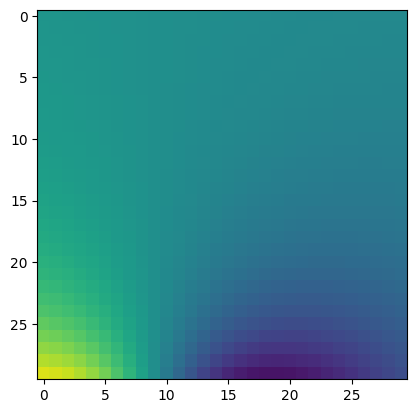

[0.00000000e+00 2.32047907e-08 0.00000000e+00]


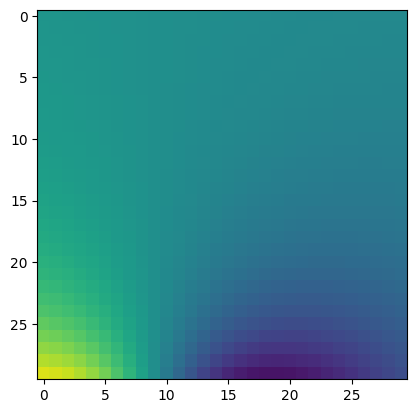

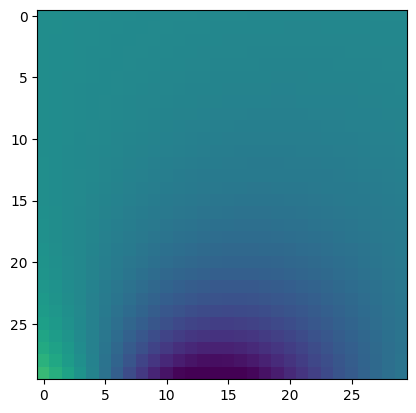

[0.00000000e+00 1.64082649e-08 1.64082649e-08]


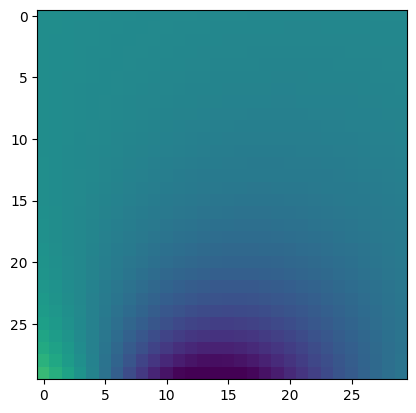

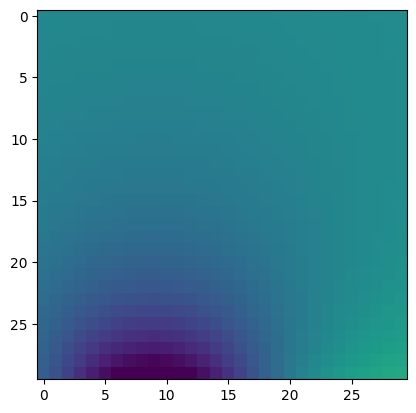

[0.00000000e+00 1.42088363e-24 2.32047907e-08]


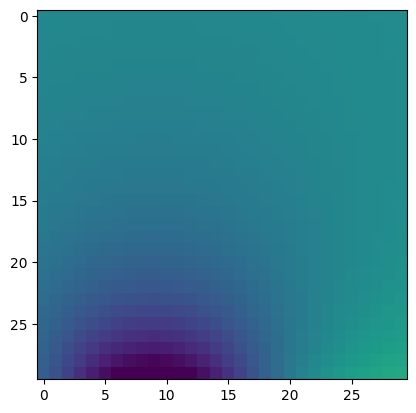

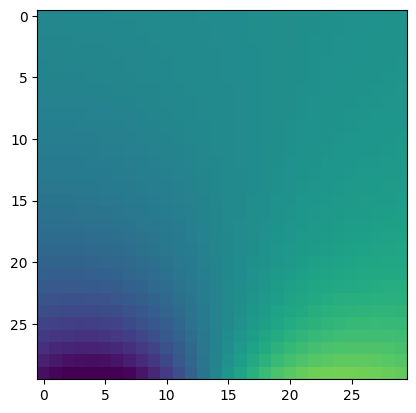

[ 0.00000000e+00 -1.64082649e-08  1.64082649e-08]


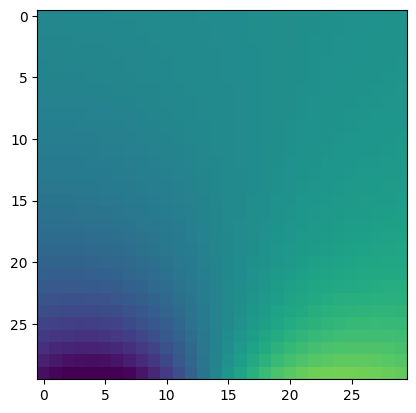

In [7]:
plt.cla()
for i in range(4):
    alpha = i*np.pi/4
    plt.imshow(magnetFields[1,:,:,2,0]*np.cos(alpha)+magnetFields[1,:,:,1,0]*np.sin(alpha),vmin=-5e-3, vmax=5e-3)
    plt.show()
    magnet = shimming_magnets[0]
    magnet.rotation_yz = alpha
    magnet.render_field(grid=coordinate_grid)
    plt.imshow(magnet.B0[1,:,:,2],vmin=-5e-6, vmax=5e-6)

    #plt.imshow(b0map.interpolatedField[1,:,:])
    plt.show()

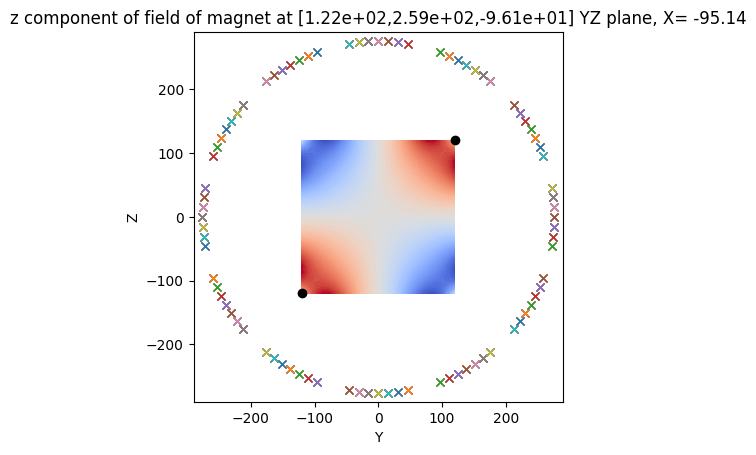

In [8]:
# visualize the field of one magnet
resolution = 1/resolution_of_sph_fit*1e3

X = b0map.xDim_SPH_fine*1e0
Y = b0map.yDim_SPH_fine*1e0
Z = b0map.zDim_SPH_fine*1e0

ONEMAGNETFIELD = magnetFields[:,:,:,:,0]*0

ax = plt.figure().add_subplot()
for idx in range(0,336,1):

    position = positions[idx]

    x,y,z = coordinate_grid
    y2d, z2d = np.meshgrid(Y,Z,indexing='xy')

    ONEMAGNETFIELD += magnetFields[:,:,:,:,idx]#+magnetFields[:,:,:,:,idx+14]

    
    
    
    ax.plot(position[1]*1000,position[2]*1000,'x')
scale = 5e-0
yzsliceindex = 3
ax.contourf(y2d,z2d,ONEMAGNETFIELD[yzsliceindex,:,:,2],cmap='coolwarm',levels=64)#,vmin = -scale, vmax= scale)

ax.plot(min(Y),min(Z),'ko')
ax.plot(max(Y),max(Z),'ko')

ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_xlim(-290,290)
ax.set_ylim(-290,290)
ax.set_aspect(1)
                
ax.set_title('z component of field of magnet at [%.2e,%.2e,%.2e] YZ plane, X= %.2f'%(position[0]*1e3,position[1]*1e3,position[2]*1e3,X[yzsliceindex]))

plt.show()

(30, 30, 30, 3, 336)


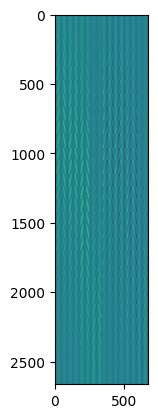

In [9]:
# mask the magnet fields
# DSV = b0map.path.radius*2 # DEFINED ABOVE!
DSV_INNER = b0map.path.radius*1.85#1.95 # DEFINED ABOVE!
# make a spherical mask with diameter DSV
sphereMask = np.zeros(np.shape(coordinate_grid[0]), dtype = float)
sphereMask[np.square(coordinate_grid[0]) + np.square(coordinate_grid[1]) + np.square(coordinate_grid[2]) <= (DSV/2)**2] = 1 
sphereMask[np.square(coordinate_grid[0]) + np.square(coordinate_grid[1]) + np.square(coordinate_grid[2]) <= (DSV_INNER/2)**2] = 0 

sphereMask[sphereMask == 0] = np.nan

print(np.shape(magnetFields))

maskedFields = magnetFields[sphereMask == 1, :,:].astype(float)
maskedFields_stacked = np.hstack((maskedFields[:,1,:],maskedFields[:,2,:])) # WE HAVE Y AND Z


plt.imshow(maskedFields_stacked) #



In [10]:
# masking the magnet fields

print(np.shape(maskedFields_stacked))

vector_of_magnet_rotations = np.zeros(len(shimming_magnets))

stackedRotationVector = np.hstack([np.sin(vector_of_magnet_rotations),np.cos(vector_of_magnet_rotations)])
print(np.shape(stackedRotationVector))

rotatedFieldOfShimMagnetsStacked = np.matmul(maskedFields_stacked,stackedRotationVector)

print(np.shape(rotatedFieldOfShimMagnetsStacked))


(2664, 672)
(672,)
(2664,)


In [13]:
#plt.imshow(initialField[1,:,:])

initialFieldMasked = initialField[sphereMask == 1]
print(np.shape(initialFieldMasked))
print(np.shape(initialField))

(2664,)
(30, 30, 30)


In [14]:
# ok now we have magnet fields and vector of magnet rotations. we can make fields now
def _dataFitting(shimVector):
            #factor = 1+np.random.randint(10)/1000
            #shimVector = shimVector*factor
            stackedRotationVector = np.hstack([np.sin(shimVector),np.cos(shimVector)])
            shimField = np.matmul(maskedFields_stacked*1.00,stackedRotationVector)+initialFieldMasked
            #optimizedField = np.matmul(magnetFields[...,1,:], np.cos(shimVector)) + np.matmul(magnetFields[...,2,:], np.sin(shimVector))
            #shimField = optimizedField + initialField
            #shimField[np.isnan(shimField)] = np.nanmean(shimField)*1
            #shimField = shimField[~np.isnan(shimField)]
            

            #shimField = shimField.flatten()

            return np.square(((shimField)/np.mean(shimField)) -1)*1e9


[ 0.00000000e+00 -1.64082649e-08  1.64082649e-08]
[ 0.00000000e+00  2.32047907e-08 -8.38667573e-19]
[ 0.00000000e+00  2.32047907e-08 -2.14051847e-18]
[ 0.00000000e+00 -9.75617479e-09  2.10542006e-08]
[ 0.00000000e+00 -9.34807607e-09  2.12385448e-08]
[ 0.00000000e+00 -8.04951555e-09  2.17639061e-08]
[ 0.00000000e+00 -6.13365398e-09  2.23794683e-08]
[ 0.00000000e+00 -4.24894985e-09  2.28124689e-08]
[ 0.00000000e+00 -6.23489426e-09  2.23514743e-08]
[ 0.00000000e+00 -1.08470897e-08  2.05134823e-08]
[ 0.00000000e+00 -2.07127205e-08  1.04616214e-08]
[ 0.00000000e+00 -1.10802033e-08 -2.03885116e-08]
[ 0.00000000e+00  1.80699569e-09 -2.31343268e-08]
[ 0.00000000e+00  7.77594557e-09 -2.18631421e-08]
[ 0.00000000e+00  1.19107510e-08 -1.99147263e-08]
[ 0.00000000e+00  2.06775601e-08 -1.05309459e-08]
[ 0.00000000e+00  2.20880557e-08 -7.11196939e-09]
[ 0.00000000e+00  2.29359636e-08 -3.52191512e-09]
[ 0.00000000e+00  2.32047894e-08 -7.88314191e-12]
[0.00000000e+00 2.28478403e-08 4.05444248e-09]
[ 0

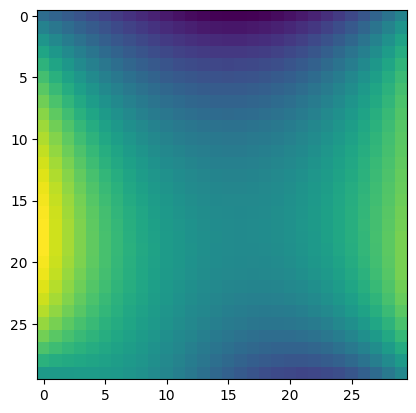

In [15]:
#render the field of rotated magnets
#optimized_vector_of_magnet_rotations = np.zeros(len(shimming_magnets))#+np.pi/4*8.05#np.random.randint(40)*2*np.pi/40
optimized_vector_of_magnet_rotations = np.load('opt1e3.npy')
shimming_magnets[0].render_field(coordinate_grid)
shimFieldRendered = shimming_magnets[0].B0*0

for idx, magnet in enumerate(shimming_magnets):
    alpha = optimized_vector_of_magnet_rotations[idx]
    magnet.rotation_yz = alpha
    magnet.render_field(grid=coordinate_grid)
    shimFieldRendered += magnet.B0

plt.imshow(shimFieldRendered[2,:,:,2])


In [17]:
# now do the least squares optimization
vector_of_magnet_rotations =np.load('opt1e3.npy')#
#vector_of_magnet_rotations = np.zeros(len(shimming_magnets))#vector_of_magnet_rotations*0 ##
cost = _dataFitting(vector_of_magnet_rotations)

print(np.sum(cost))

# least squares optimization of the rotation vector
from scipy.optimize import least_squares

initialGuess = vector_of_magnet_rotations
#initialGuess[initialGuess<0.001] = 0.001
lsqData = least_squares(_dataFitting, initialGuess, max_nfev=6400, xtol = 1e-4,ftol=0, verbose=2,bounds=(initialGuess*0,initialGuess*0+2*np.pi))


66310.83272858209
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0288e+06                                    1.51e+02    
       1              6         2.0288e+06      4.26e-01       1.06e-02       6.89e+02    
       2              7         2.0288e+06      1.72e+00       4.40e-03       2.82e+02    
`xtol` termination condition is satisfied.
Function evaluations 7, initial cost 2.0288e+06, final cost 2.0288e+06, first-order optimality 2.82e+02.


In [19]:
optimized_vector_of_magnet_rotations = lsqData.x
np.save('opt1e3',optimized_vector_of_magnet_rotations)
#np.save('opt336magnets_27mm_1607ppm',optimized_vector_of_magnet_rotations)

#print(optimized_vector_of_magnet_rotations)

shimFieldRendered = shimming_magnets[0].B0[:,:,:,2]*0

for idx, magnet in enumerate(shimming_magnets):
    alpha = optimized_vector_of_magnet_rotations[idx]
    magnet.rotation_yz = alpha#+2*np.pi/4
    #pos = positions[idx]
    magnet.position = positions[idx]
    #magnet.update_rotation(rotation_yz=alpha+0*np.pi/2)
    magnet.render_field(grid=coordinate_grid)
    shimFieldRendered += magnet.B0[:,:,:,2]#magnet.B0[:,:,:,1]*np.sin(alpha)+magnet.B0[:,:,:,2]*np.cos(alpha)

shimField_fair = initialField+shimFieldRendered*1.00e3#[:,:,:]*1+np.multiply(shimFieldRendered[:,:,:,2]*1000,lsqData.x)#+shimFieldRendered[:,:,:,1]*1000 #???? why 1st not 2nd component!?!!s


optimizedField = np.matmul(magnetFields[...,1,:], np.sin(lsqData.x)) + np.matmul(magnetFields[...,2,:], np.cos(lsqData.x))
#print(np.shape(optimizedField))



shimField = initialField+optimizedField

homoinit = (np.nanmax(initialField)-np.nanmin(initialField))/np.nanmean(initialField)*1e6
homo_cheap = (np.nanmax(shimField)-np.nanmin(shimField))/np.nanmean(shimField)*1e6
print('inhomogeneity ppm %.0f -> %.0f'%(abs(homoinit),abs(homo_cheap)))
print('mean mT %.2f -> %.2f'%(abs(np.nanmin(initialField)),abs(np.nanmin(shimField))))


homoinit = (np.nanmax(initialField)-np.nanmin(initialField))/np.nanmean(initialField)*1e6
homo_fair = (np.nanmax(shimField_fair)-np.nanmin(shimField_fair))/np.nanmean(shimField_fair)*1e6
print('inhomogeneity ppm %.0f -> %.0f'%(abs(homoinit),abs(homo_fair)))
print('mean mT %.2f -> %.2f'%(abs(np.nanmin(initialField)),abs(np.nanmin(shimField))))

shimoffset = np.nanmean(shimField) - np.nanmean(initialField)
#d = np.shape(coordinate_grid[0])
#print(d[0])



[ 0.00000000e+00  2.32047907e-08 -1.16571215e-17]
[ 0.00000000e+00  2.32047907e-08 -1.17877477e-17]
[ 0.0000000e+00 -9.7628374e-09  2.1051112e-08]
[ 0.00000000e+00 -9.34767180e-09  2.12387227e-08]
[ 0.00000000e+00 -8.06125727e-09  2.17595598e-08]
[ 0.0000000e+00 -6.1199270e-09  2.2383226e-08]
[ 0.00000000e+00 -4.25093508e-09  2.28120990e-08]
[ 0.00000000e+00 -6.24044665e-09  2.23499248e-08]
[ 0.00000000e+00 -1.08578951e-08  2.05077650e-08]
[ 0.00000000e+00 -2.07041160e-08  1.04786397e-08]
[ 0.00000000e+00 -1.10789401e-08 -2.03891980e-08]
[ 0.00000000e+00  1.80885156e-09 -2.31341818e-08]
[ 0.00000000e+00  7.77846129e-09 -2.18622472e-08]
[ 0.00000000e+00  1.19012824e-08 -1.99203862e-08]
[ 0.00000000e+00  2.06784364e-08 -1.05292249e-08]
[ 0.00000000e+00  2.20884406e-08 -7.11077383e-09]
[ 0.00000000e+00  2.29358843e-08 -3.52243103e-09]
[ 0.00000000e+00  2.32047894e-08 -7.85097014e-12]
[0.00000000e+00 2.28486793e-08 4.04971202e-09]
[ 0.00000000e+00  2.32047907e-08 -7.87513426e-15]
[ 0.00000

inhomogeneity ppm 5384 -> 917
mean mT 47.70 -> 47.34
30


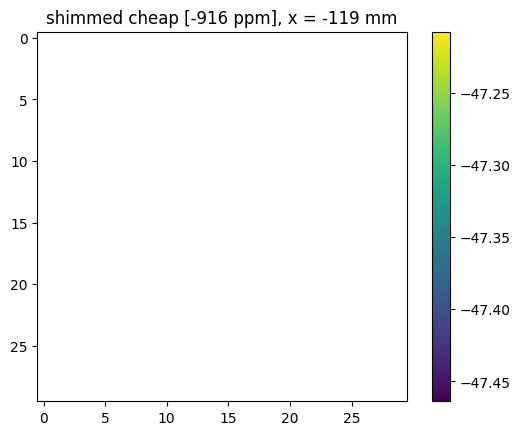

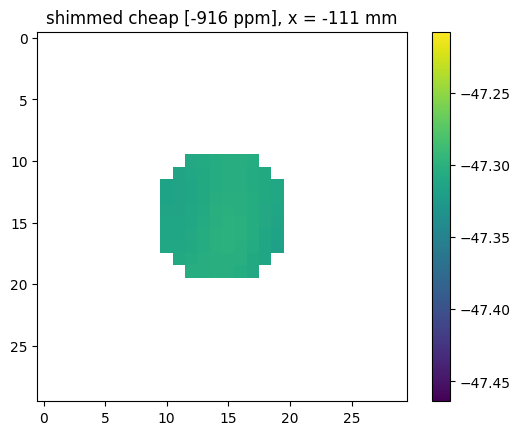

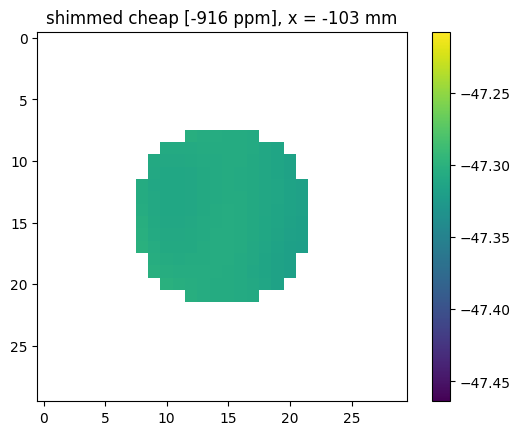

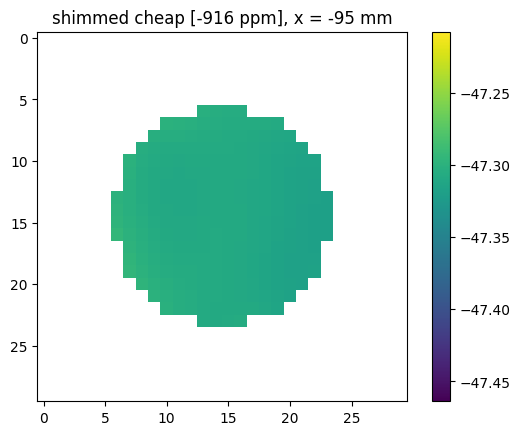

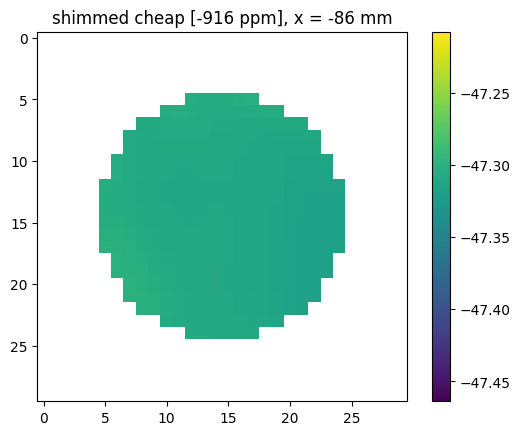

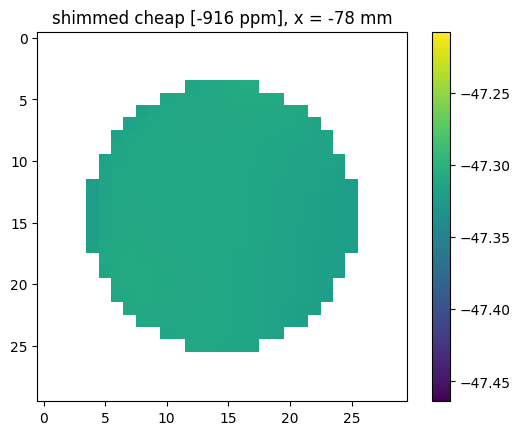

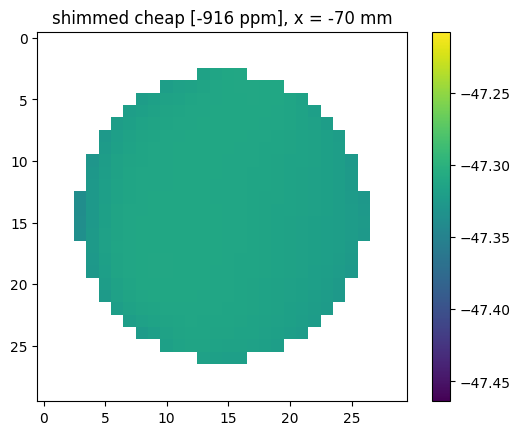

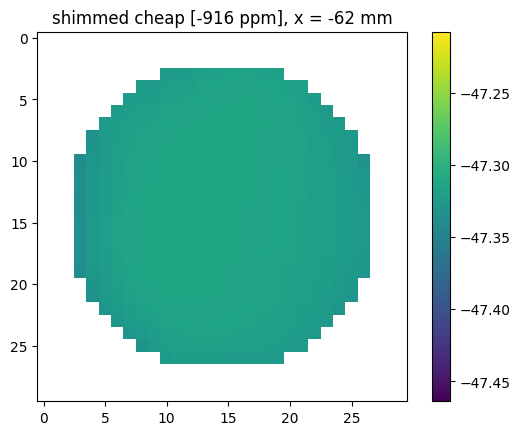

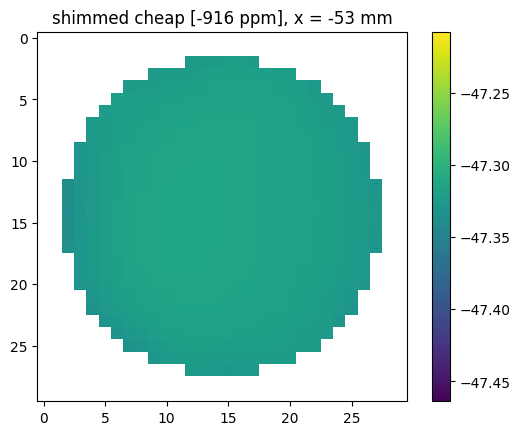

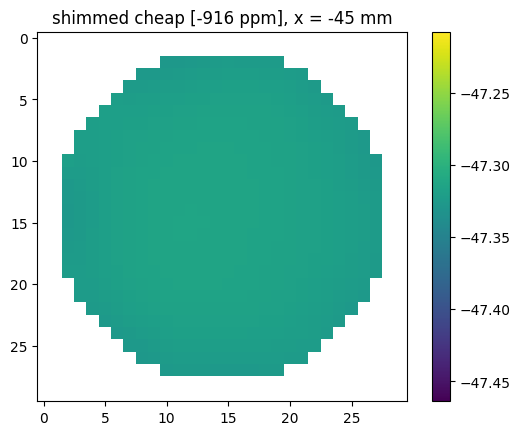

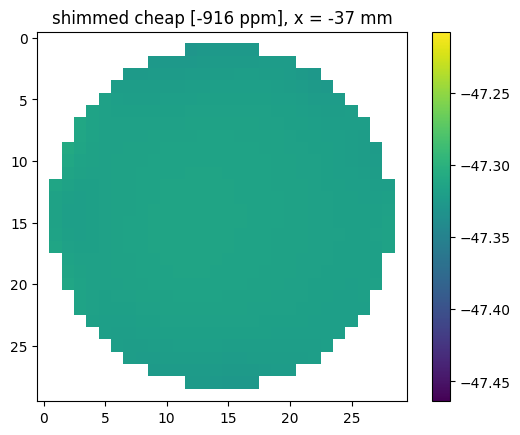

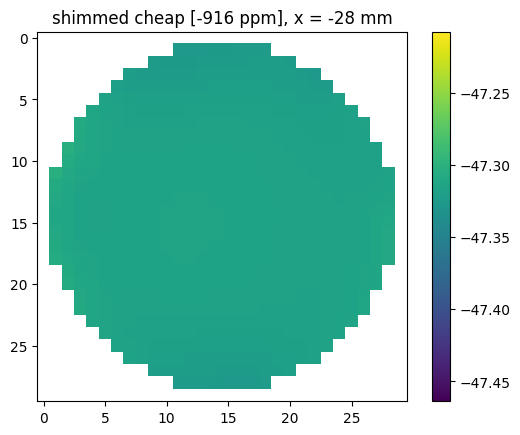

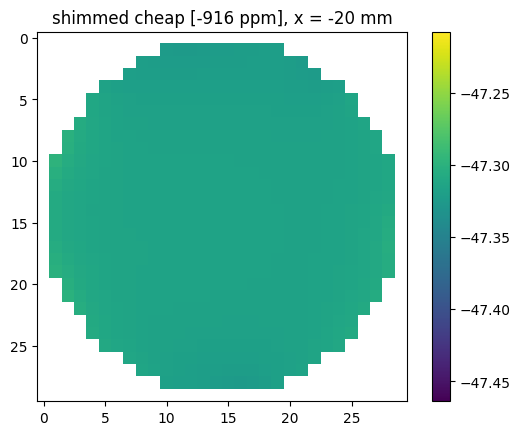

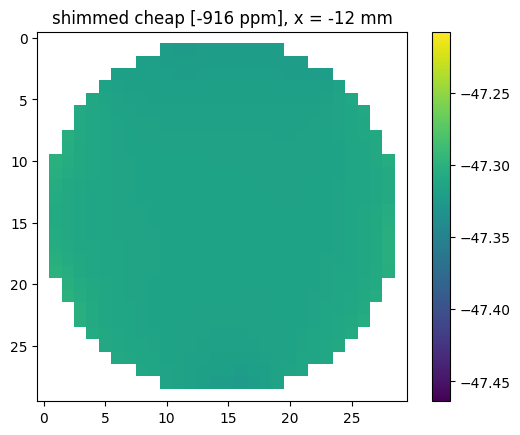

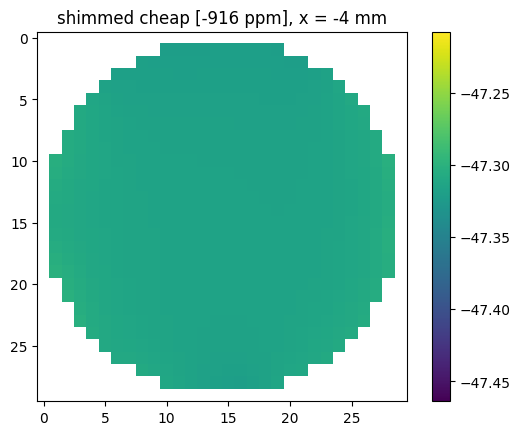

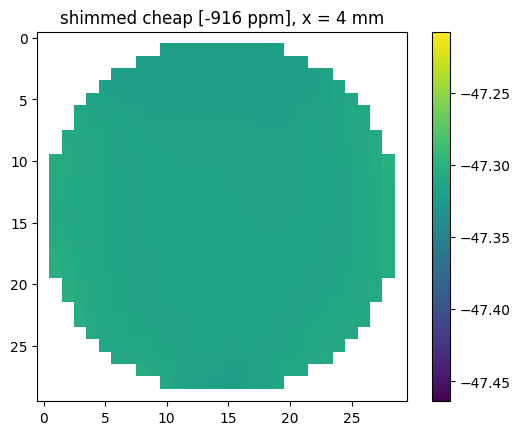

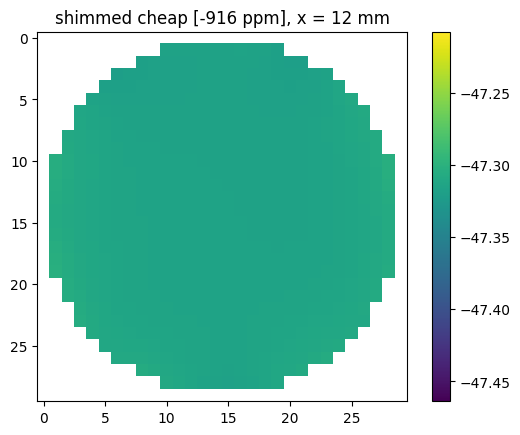

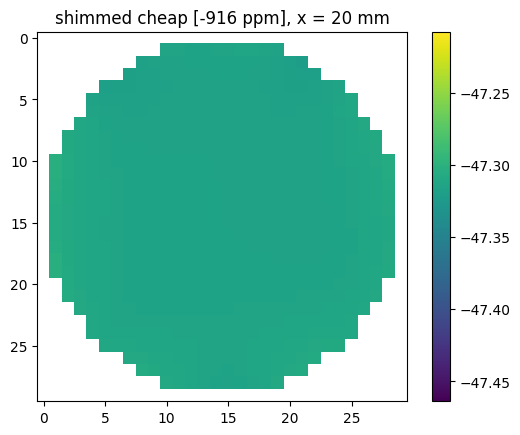

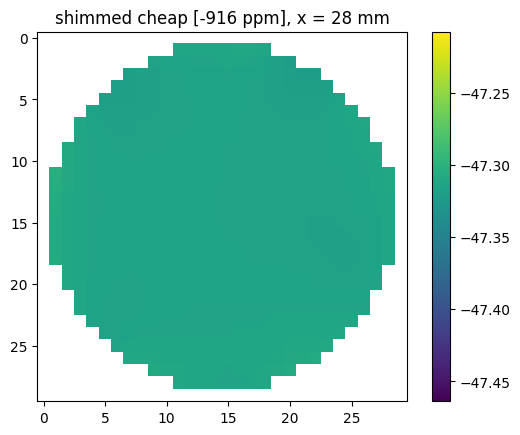

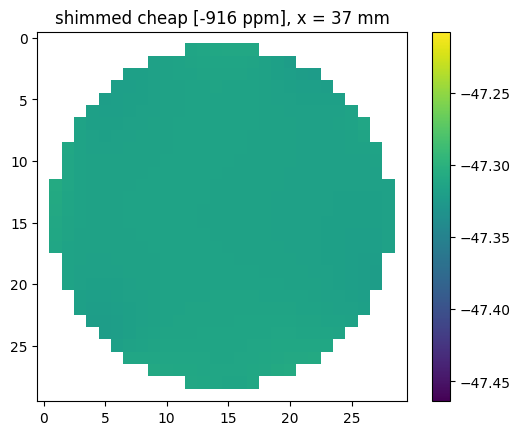

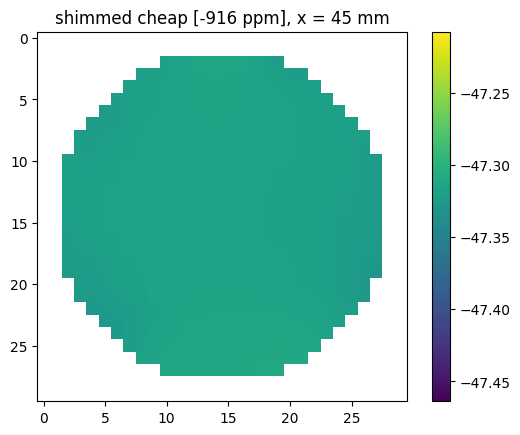

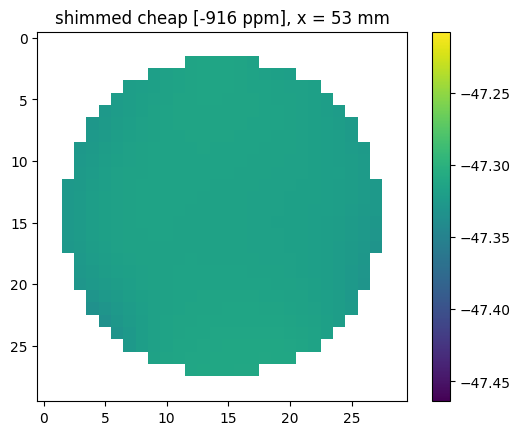

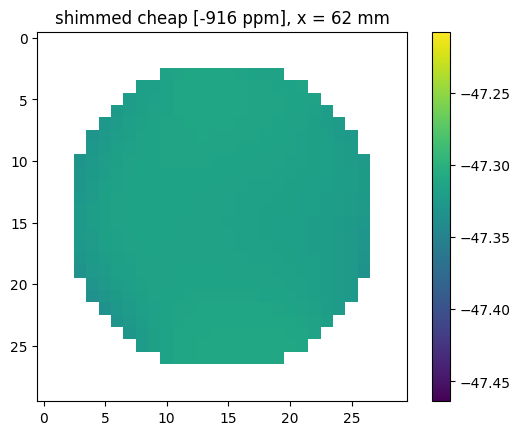

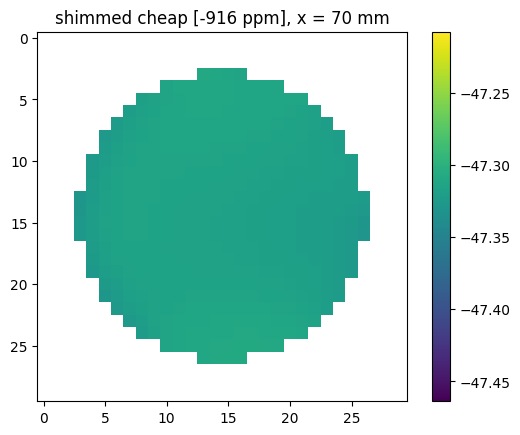

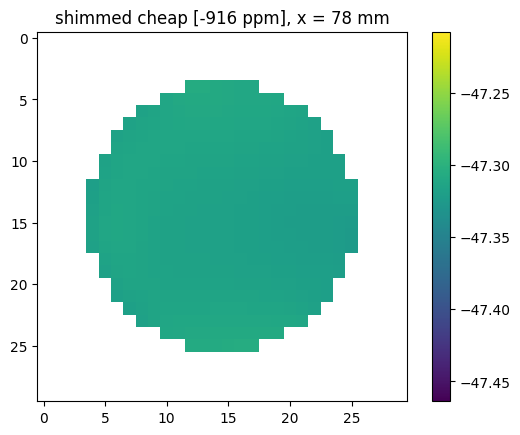

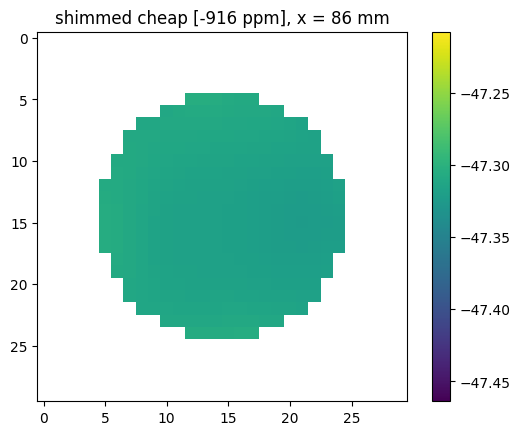

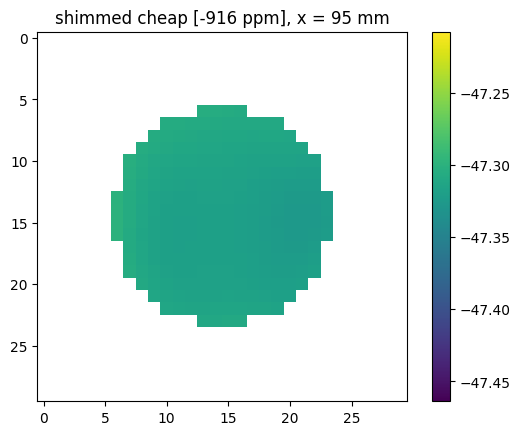

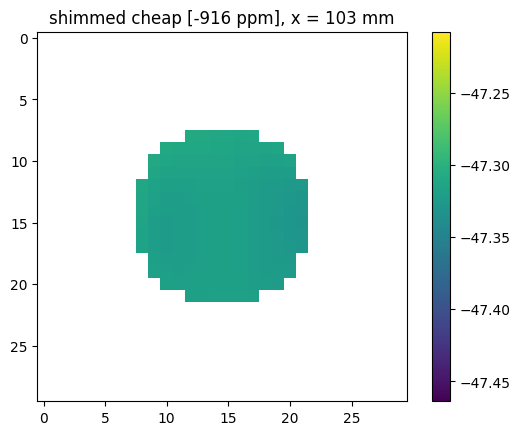

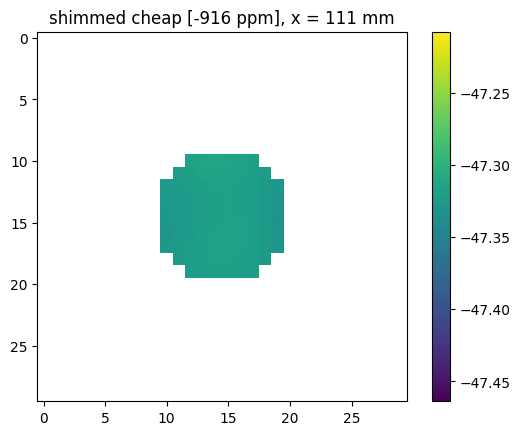

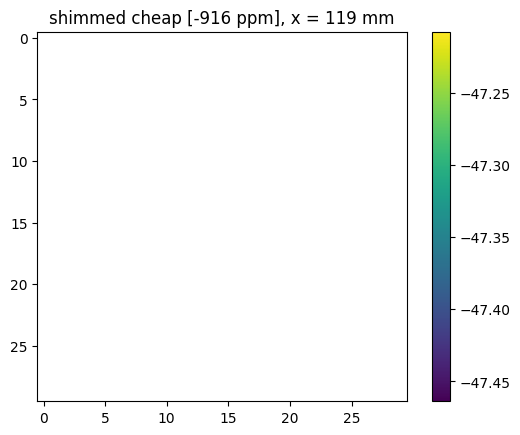

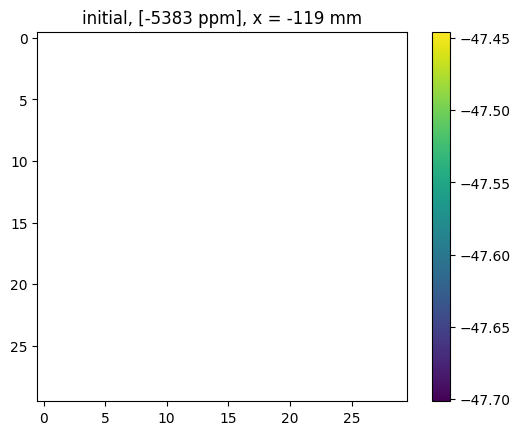

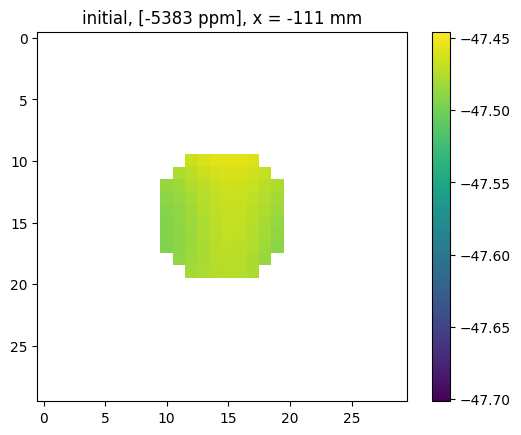

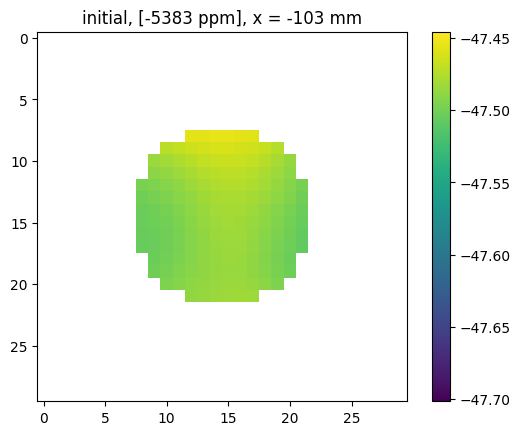

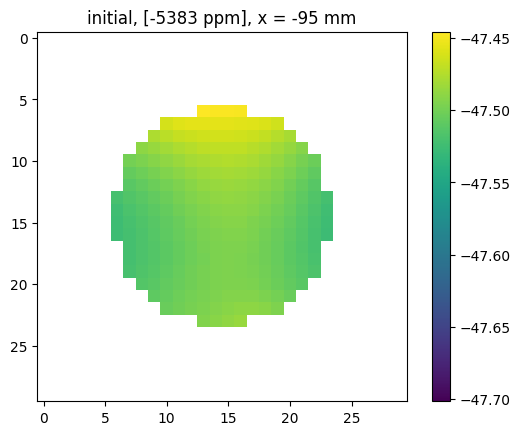

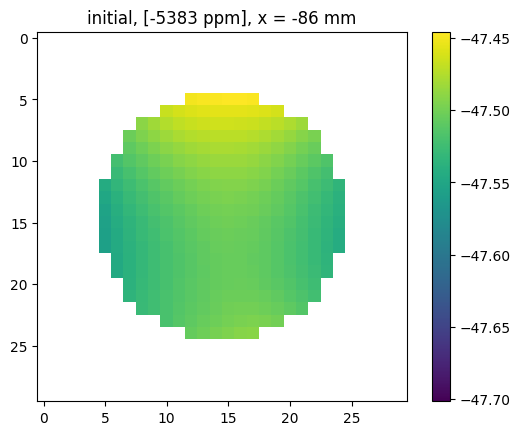

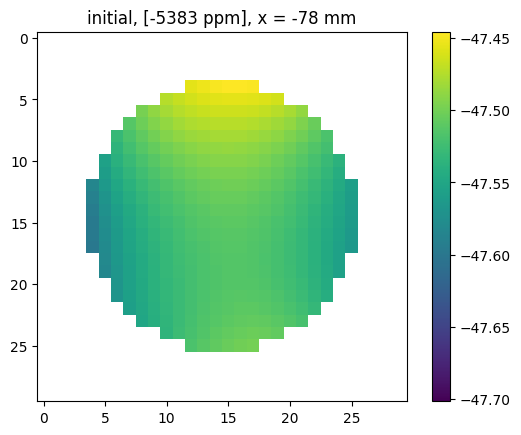

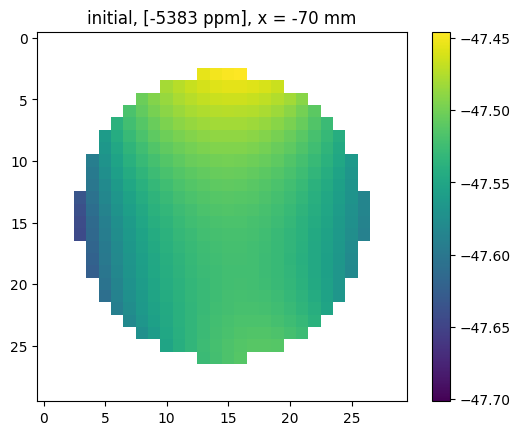

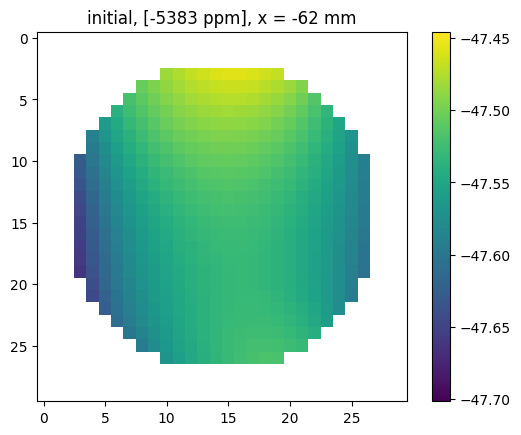

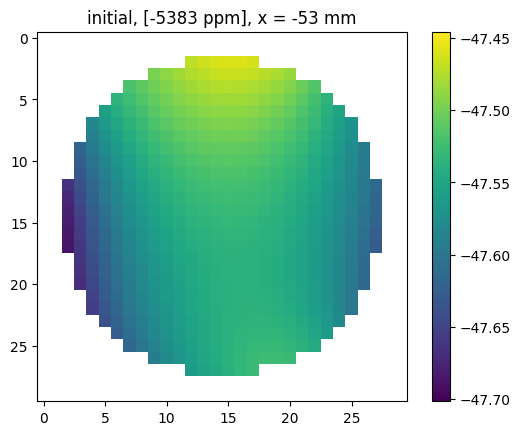

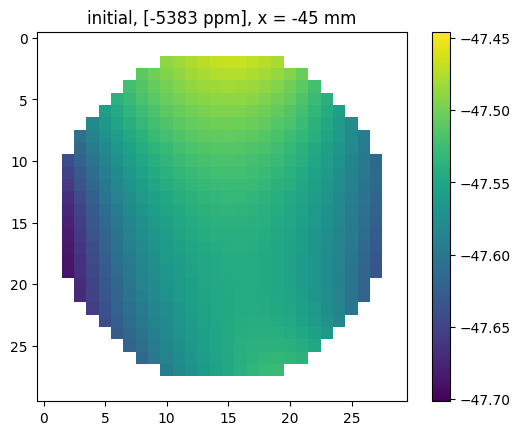

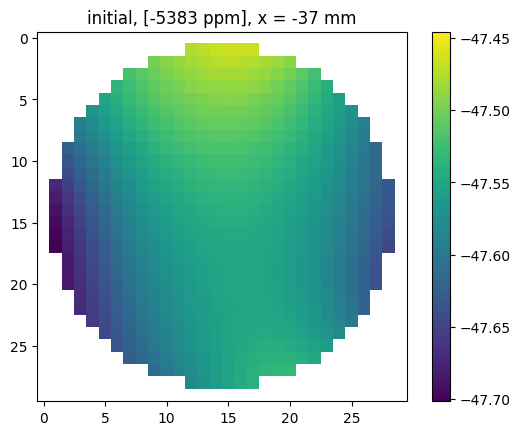

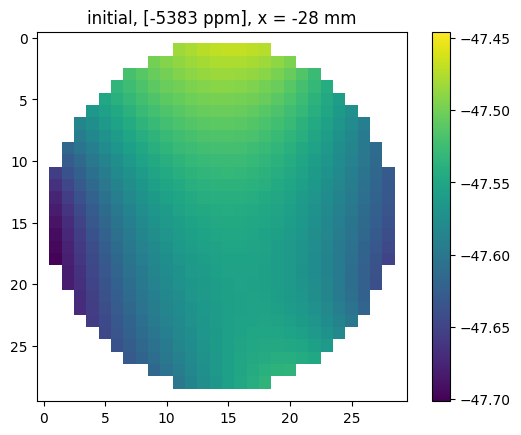

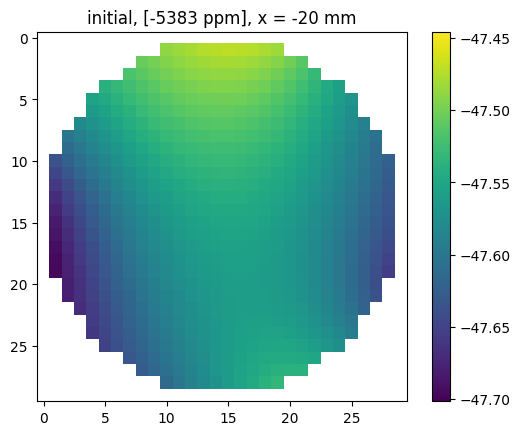

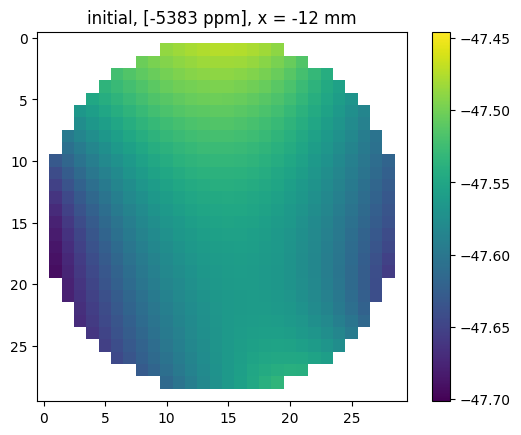

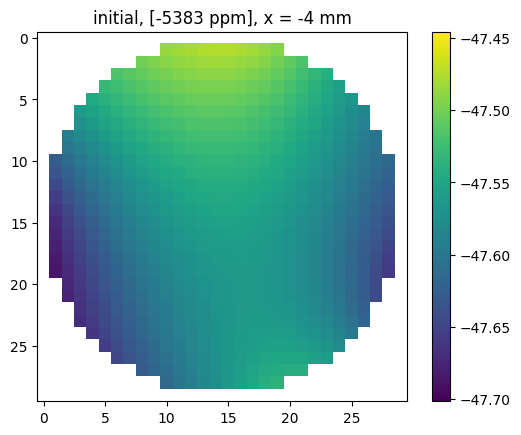

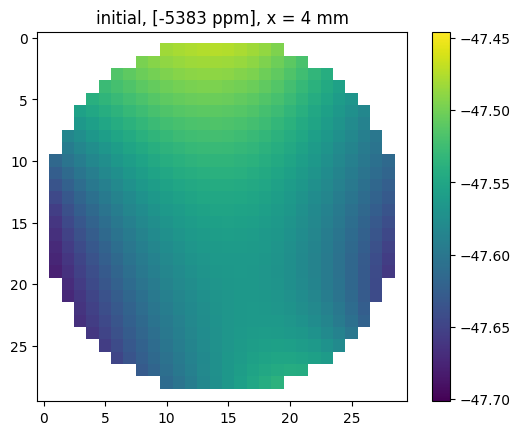

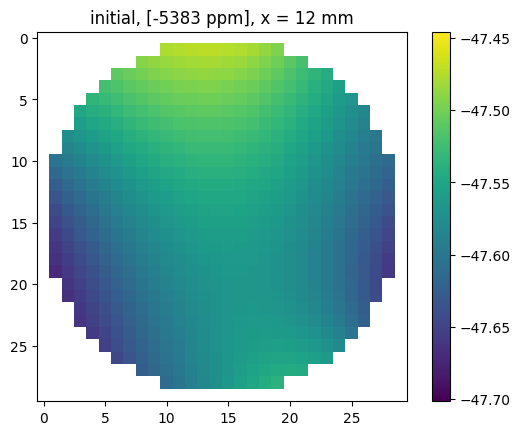

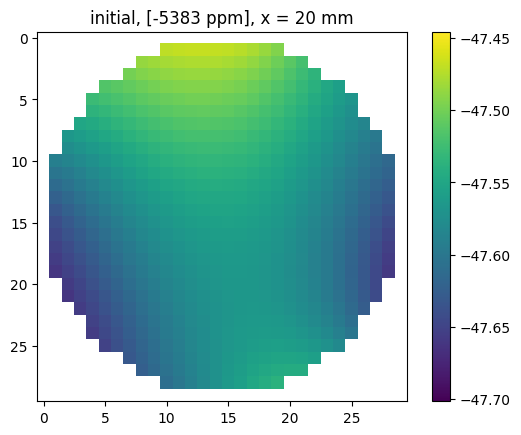

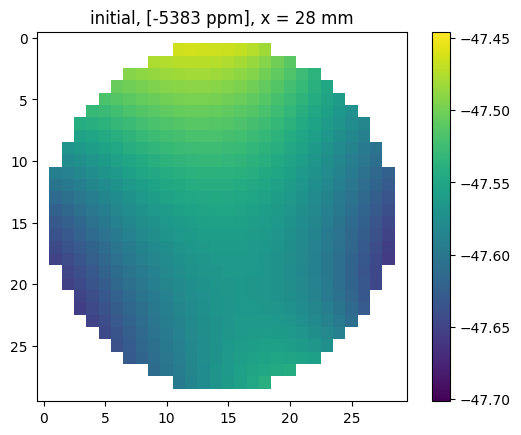

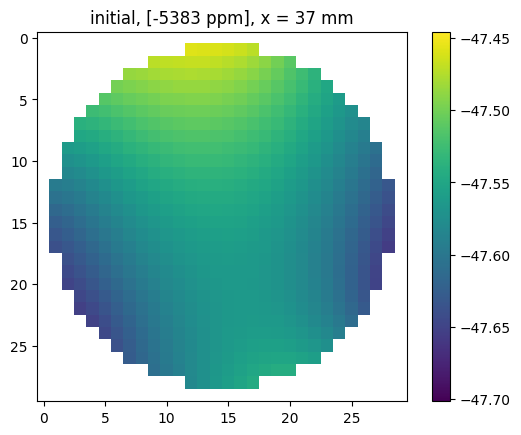

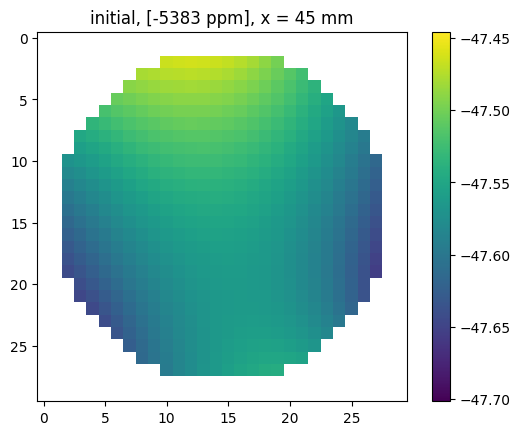

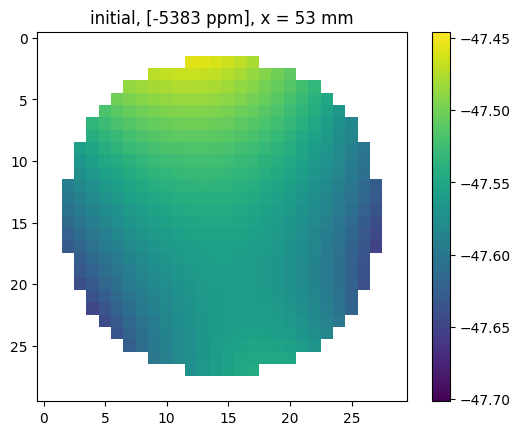

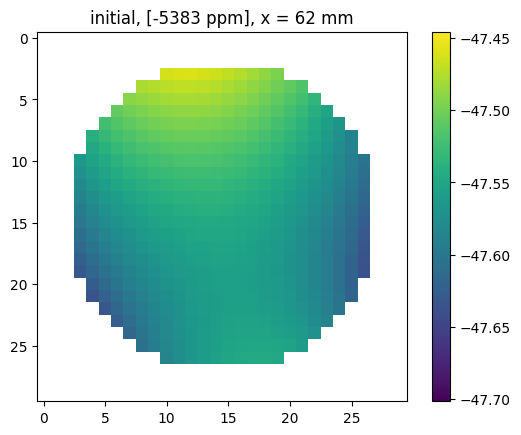

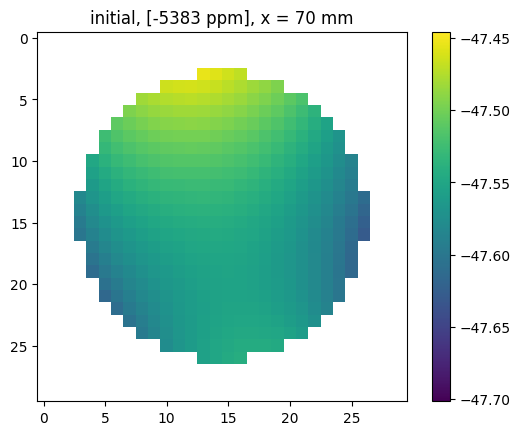

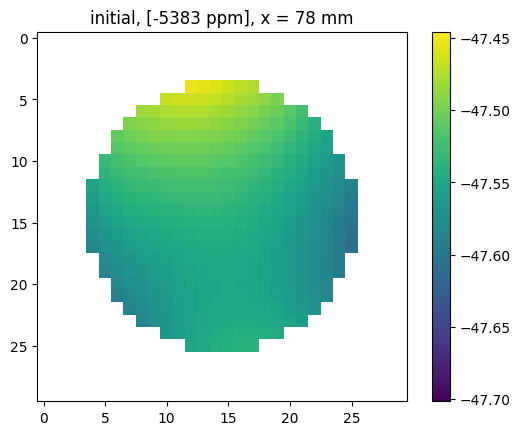

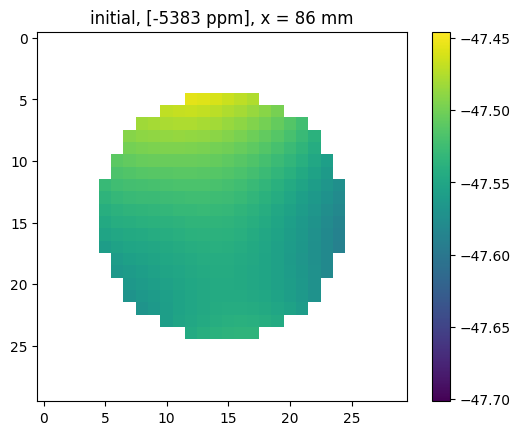

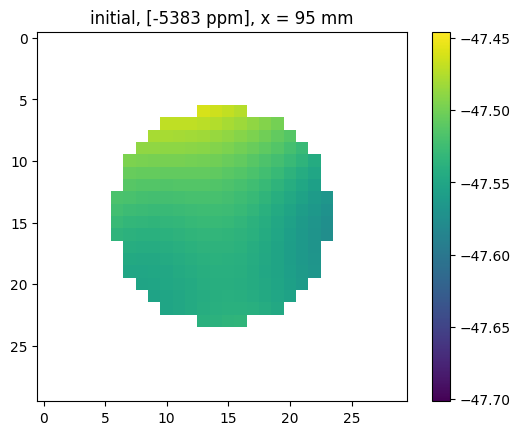

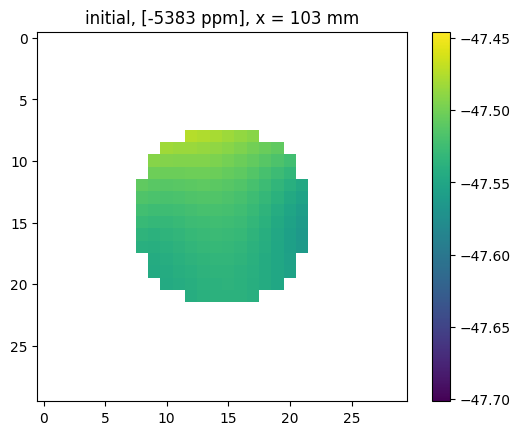

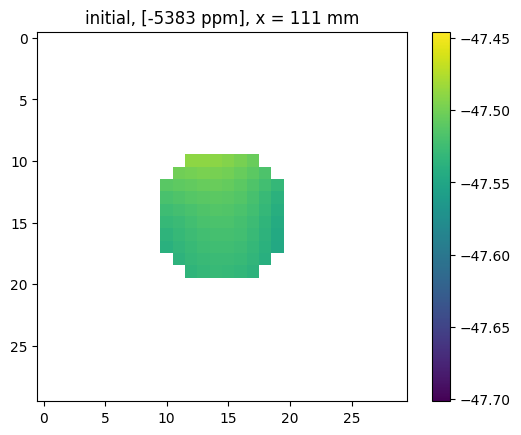

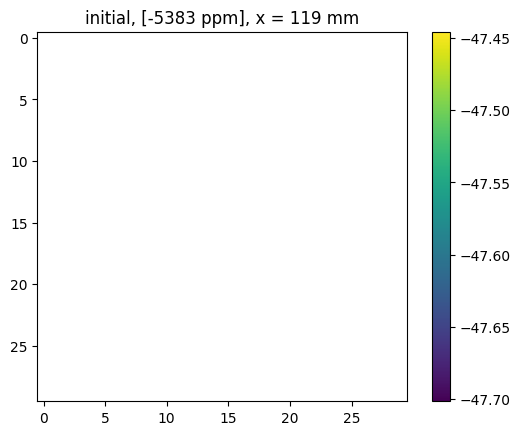

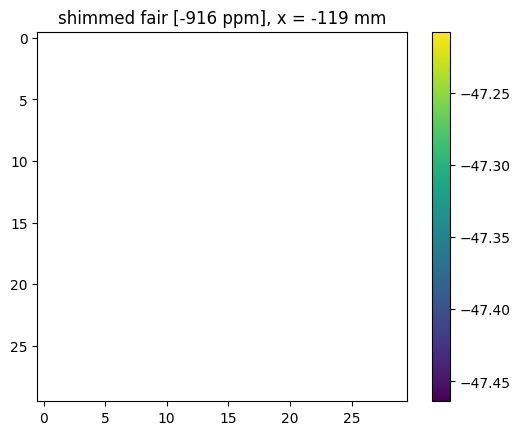

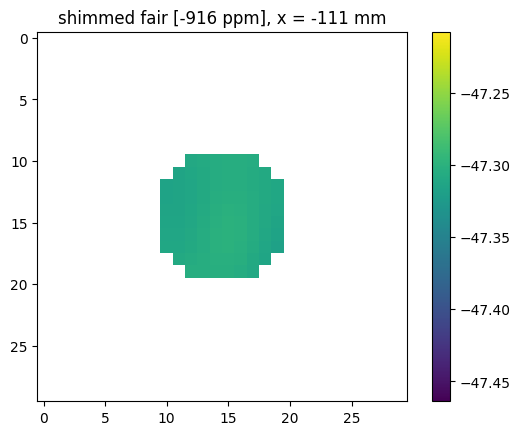

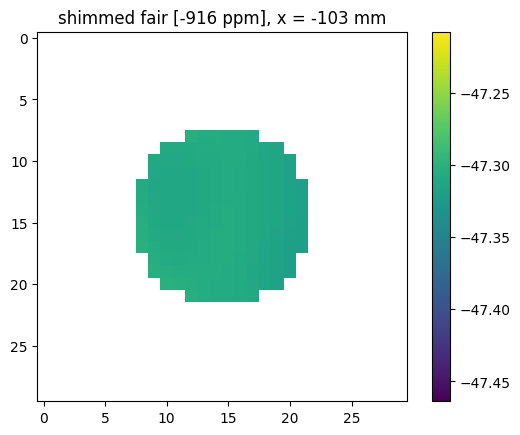

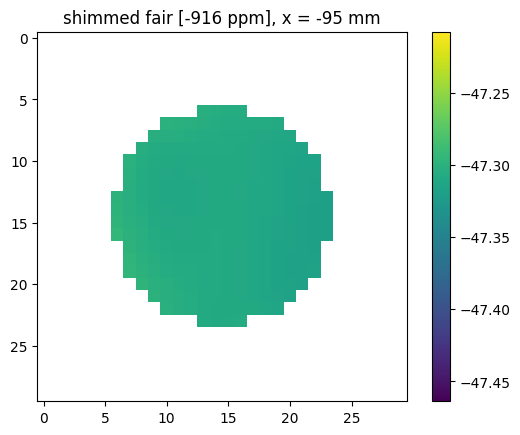

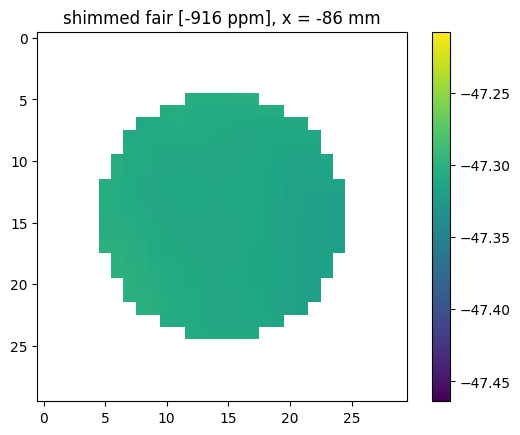

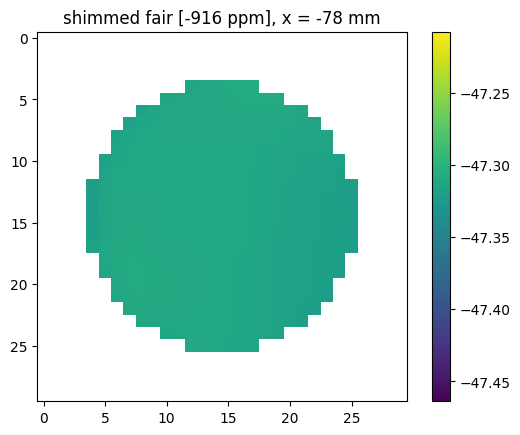

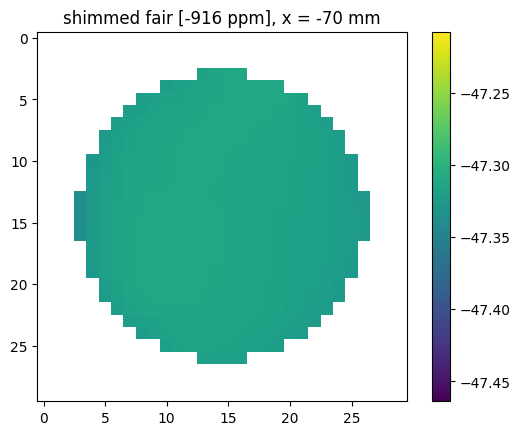

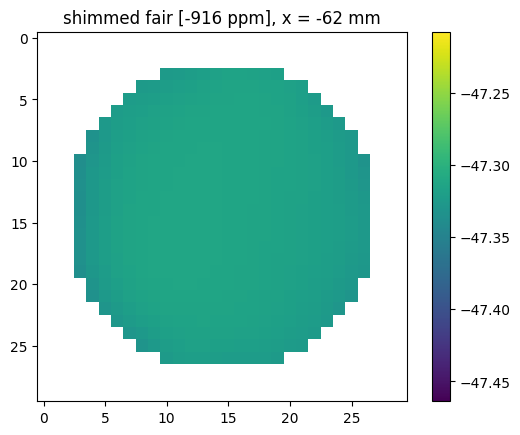

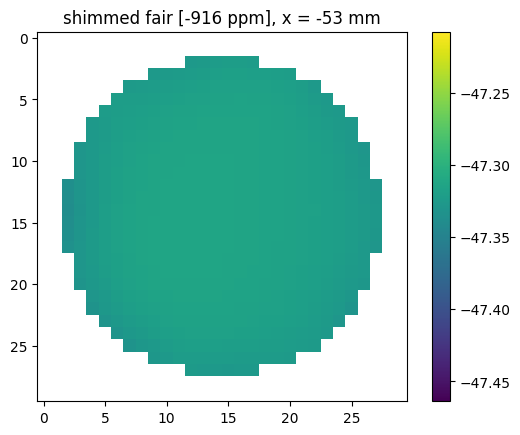

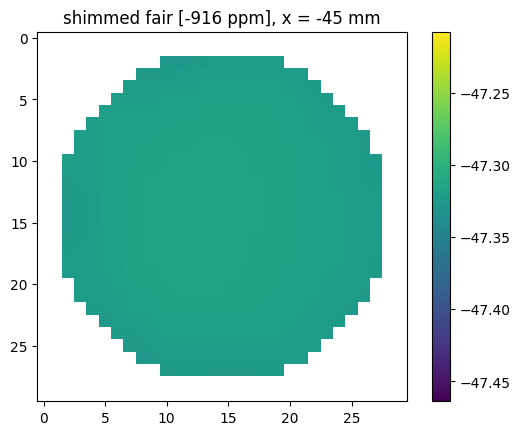

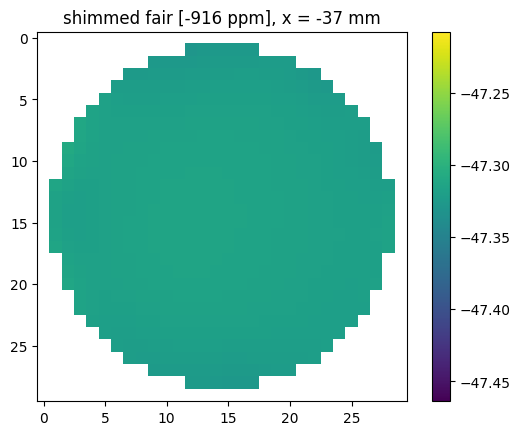

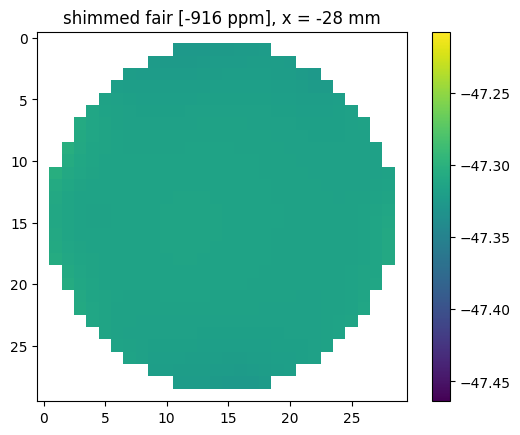

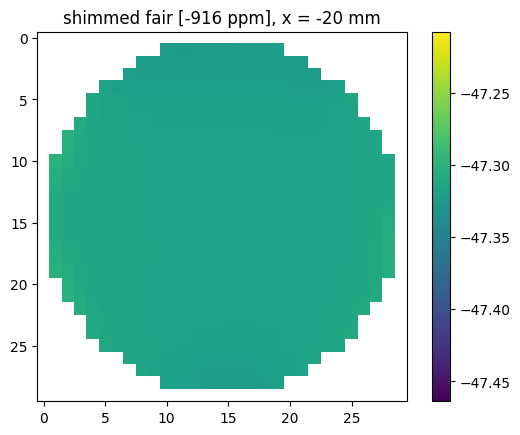

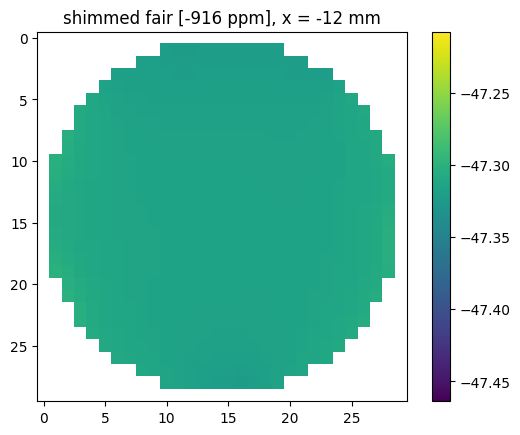

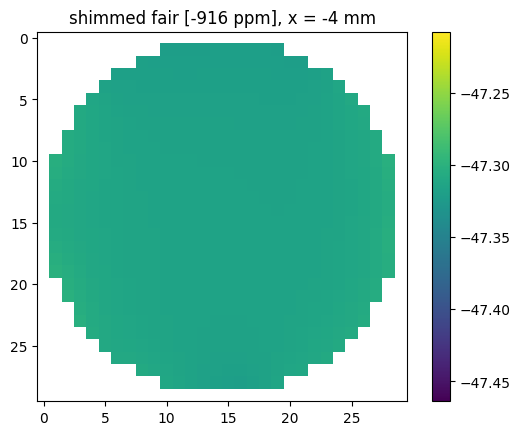

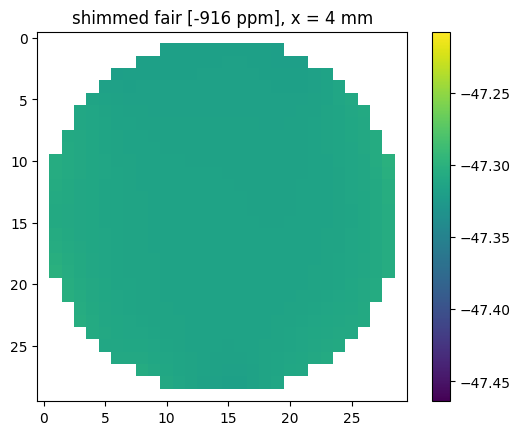

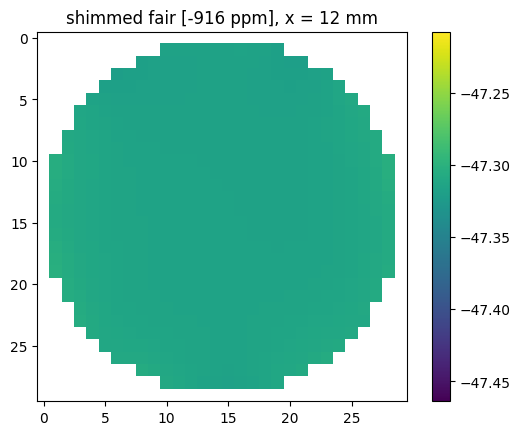

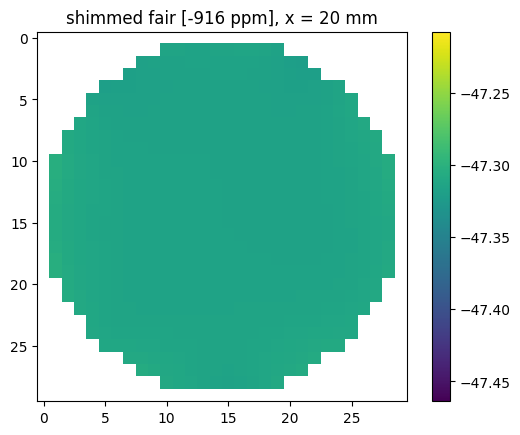

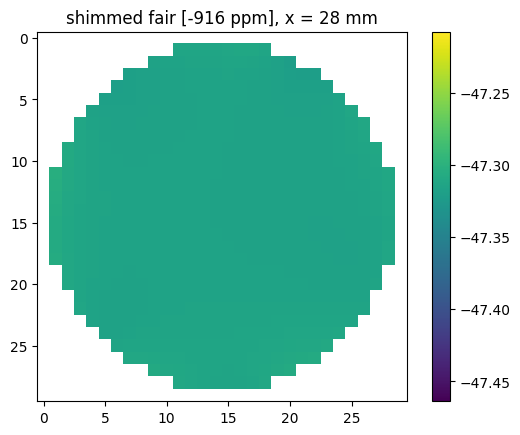

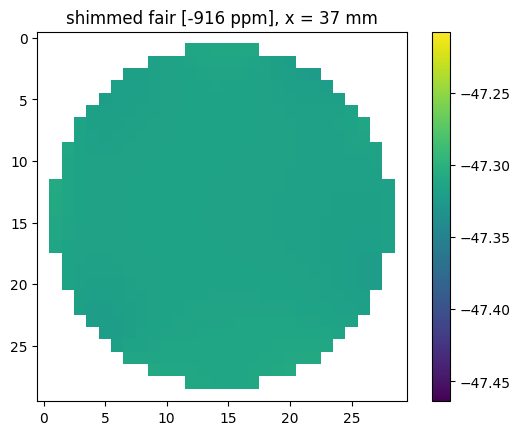

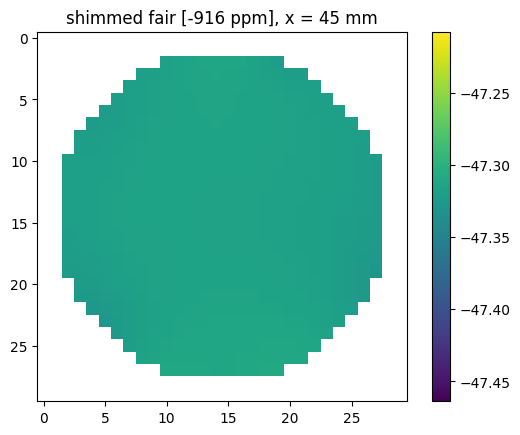

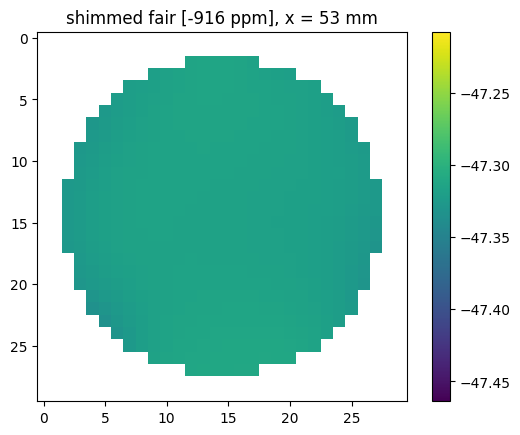

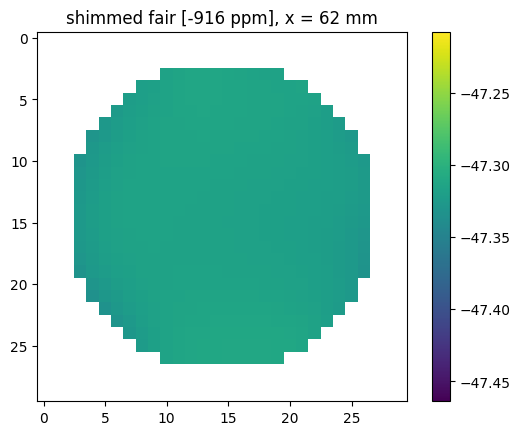

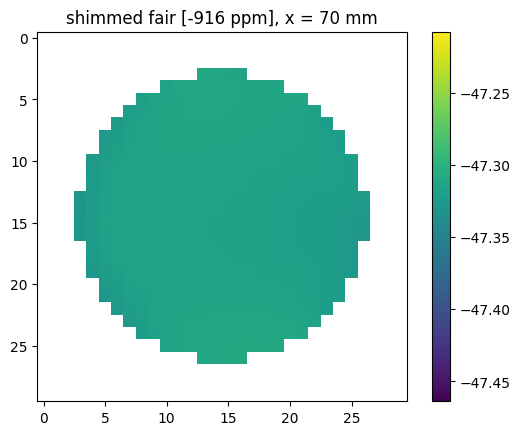

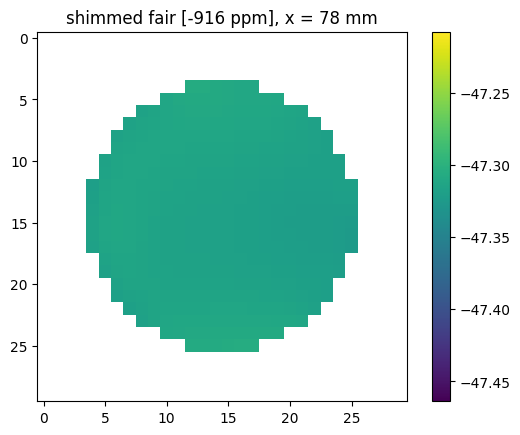

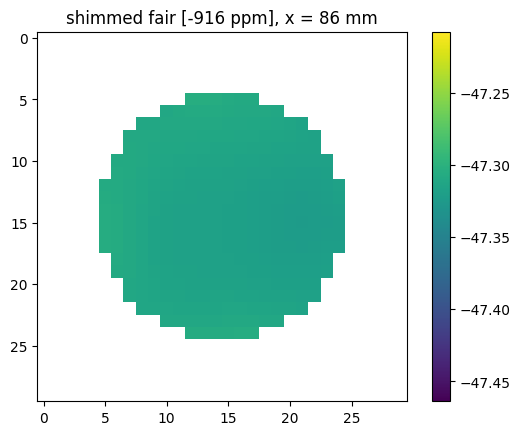

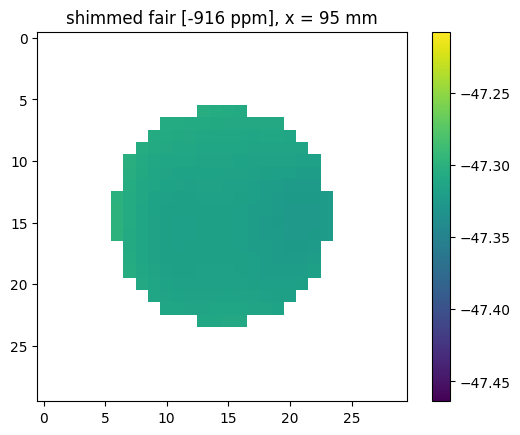

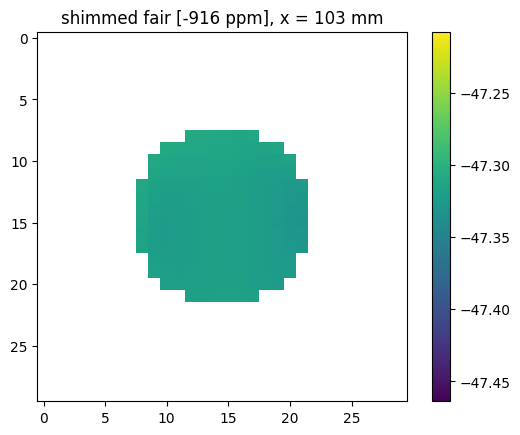

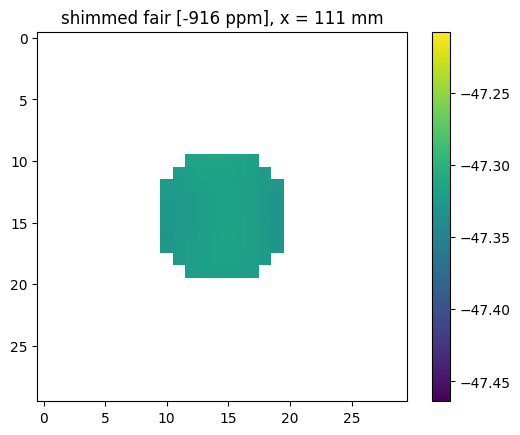

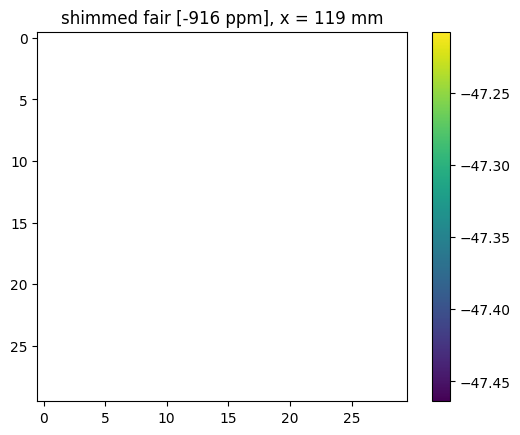

<Figure size 640x480 with 0 Axes>

In [21]:


#shimField = initialField+optimizedField

homoinit = (np.nanmax(initialField)-np.nanmin(initialField))/np.nanmean(initialField)*1e6
homo = (np.nanmax(shimField)-np.nanmin(shimField))/np.nanmean(shimField)*1e6
print('inhomogeneity ppm %.0f -> %.0f'%(abs(homoinit),abs(homo)))
print('mean mT %.2f -> %.2f'%(abs(np.nanmin(initialField)),abs(np.nanmin(shimField))))

xvals = b0map.xDim_SPH_fine

shimoffset = np.nanmean(shimField) - np.nanmean(initialField)
d = np.shape(coordinate_grid[0])
print(d[0])
for i in range(d[0]):
    fig = plt.figure()
    plt.imshow(shimField[i,:,:],clim=[np.nanmin(initialField)+shimoffset,np.nanmax(initialField)+shimoffset])
    plt.colorbar()
    plt.title('shimmed cheap [%d ppm], x = %d mm'%(homo_cheap,xvals[i]))
    plt.show()
    fig.savefig('./pics/CF%d'%i)


for i in range(d[0]):
    plt.imshow(initialField[i,:,:],clim=[np.nanmin(initialField),np.nanmax(initialField)])
    plt.title('initial, [%d ppm], x = %d mm'%(homoinit,xvals[i]))
    plt.colorbar()
    plt.show()
    plt.savefig('./pics/IF%d'%i)


for i in range(d[0]):
    plt.imshow(shimField_fair[i,:,:],clim=[np.nanmin(initialField),np.nanmax(initialField)]+shimoffset)
    plt.colorbar()
    plt.title('shimmed fair [%d ppm], x = %d mm'%(homo_fair,xvals[i]))
    plt.show()
    plt.savefig('./pics/SF%d'%i)



In [22]:
#saving rings
for idx,magnet in enumerate(shimming_magnets):
      magnet.rotation = optimized_vector_of_magnet_rotations[idx]
      magnet.render_field(coordinate_grid)

def save_rings(fname:str):
        print('save magnet positions and rotations to the file')
        with open(fname, 'w') as file:
            file.write('x[m],y[m],z[m],dirx[m^2A],diry[m^2A],dirz[m^2A],rotation_xy[rad]\n')
            for idx,alpha in enumerate(optimized_vector_of_magnet_rotations):
                 pos = positions[idx]
                 magnet = shimming_magnets[idx]
                 x=pos[0]
                 y=pos[1]
                 z=pos[2]
                 dirx = magnet.dipole_vector[0]
                 diry = magnet.dipole_vector[1]
                 dirz = magnet.dipole_vector[2]     
                 rot  = alpha

                 file.write('%.4f,%.4f,%.4f,%.4e,%.4e,%.4e,%.4f\n'%(x,y,z,dirx,diry,dirz,rot))
        file.close()
        print('exported magnet rotations/positions as *txt file')

save_rings('./shimming/rings/iter2_magnets_rotations_optimized_917ppm_8mm.txt')


[ 0.00000000e+00  2.32047907e-08 -1.16571215e-17]
[ 0.00000000e+00  2.32047907e-08 -1.17877477e-17]
[ 0.0000000e+00 -9.7628374e-09  2.1051112e-08]
[ 0.00000000e+00 -9.34767180e-09  2.12387227e-08]
[ 0.00000000e+00 -8.06125727e-09  2.17595598e-08]
[ 0.0000000e+00 -6.1199270e-09  2.2383226e-08]
[ 0.00000000e+00 -4.25093508e-09  2.28120990e-08]
[ 0.00000000e+00 -6.24044665e-09  2.23499248e-08]
[ 0.00000000e+00 -1.08578951e-08  2.05077650e-08]
[ 0.00000000e+00 -2.07041160e-08  1.04786397e-08]
[ 0.00000000e+00 -1.10789401e-08 -2.03891980e-08]
[ 0.00000000e+00  1.80885156e-09 -2.31341818e-08]
[ 0.00000000e+00  7.77846129e-09 -2.18622472e-08]
[ 0.00000000e+00  1.19012824e-08 -1.99203862e-08]
[ 0.00000000e+00  2.06784364e-08 -1.05292249e-08]
[ 0.00000000e+00  2.20884406e-08 -7.11077383e-09]
[ 0.00000000e+00  2.29358843e-08 -3.52243103e-09]
[ 0.00000000e+00  2.32047894e-08 -7.85097014e-12]
[0.00000000e+00 2.28486793e-08 4.04971202e-09]
[ 0.00000000e+00  2.32047907e-08 -7.87513426e-15]
[ 0.00000

In [30]:
# making gifs

# now making a gif
from PIL import Image
import glob
import time

def make_gif_from_filename(input:str,output:str):
    # create an empty list called images
    images = []

    # get the current time to use in the filename
    timestr = time.strftime("%Y%m%d-%H%M%S")

    # get all the images in the 'images for gif' folder
    for idx in range(30): # loop through all png files in the folder
        filename = './pics/%s%d.png'%(input,idx)
        im = Image.open(filename) # open the image
        #im_small = im.resize((1080, 70), resample=1) # resize them to make them a bit smaller
        images.append(im) # add the image to the list

    # calculate the frame number of the last frame (ie the number of images)
    last_frame = (len(images)) 

    # create 10 extra copies of the last frame (to make the gif spend longer on the most recent data)
    #for x in range(0, 9):
    #    im = images[last_frame-1]
    #    images.append(im)

    # save as a gif   
    images[0].save('./gifs/%s'%output+timestr+'.gif',
                save_all=True, append_images=images[1:], optimize=False, duration=80, loop=0)
    
# cheap field gif
make_gif_from_filename(input='CF',output='shimmed_field_cheap')


In [ ]:
# now save the shimmed map for Jan
#ax = plt.figure().add_subplot(projection='3d')
#ax.scatter(b0map.path.r[:,0],b0map.path.r[:,1],b0map.path.r[:,2])
#plt.show()

# print the coordinate grid on which the field was rendered
print(np.shape(coordinate_grid))
print(len(X)) 
idx2=0

import datetime
with open("./shimming/tocomsol/shimmed_field_simulated_OSI2_V1_iter2.csv", 'w') as file:
    file.write('# Shimming of B0M %s\n'%filename_to_import_csv_data_from)
    file.write('# time %s\n'%str(datetime.datetime.now()))
    file.write('# MAGNET CENTER IN LAB: x 0 mm, y 0 mm, z 0 mm\n')
    file.write('# MAGNET AXES WRT LAB: alpha 0.00 deg, beta 0.00 deg, gamma 0.00 deg\n')
    file.write('# path: see repo\n')
    file.write('# X[mm],Y[mm],Z[mm],B0_x[mT],B0_y[mT],B0_z[mT],B0_abs[mT]\n')
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            for k,z in enumerate(Z):
                if shimField[i,j,k] <=0:
                    file.write('%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n'%(x,y,z,shimField[i,j,k],0,0,abs(shimField[i,j,k])))
                    print('%.4f,%.4f,%.4f,%.4f\n'%(x,y,z,shimField[i,j,k]))
                idx2+=1
print(np.shape(shimField))


In [ ]:

for idx,magnet in enumerate(shimming_magnets):
      magnet.rotation = optimized_vector_of_magnet_rotations[idx]
      magnet.render_field(coordinate_grid)

def save_rings(fname:str):
        print('save magnet positions and rotations to the file')
        with open(fname, 'w') as file:
            file.write('x[m],y[m],z[m],dirx[m^2A],diry[m^2A],dirz[m^2A],rotation_xy[rad]\n')
            for idx,alpha in enumerate(optimized_vector_of_magnet_rotations):
                 pos = positions[idx]
                 magnet = shimming_magnets[idx]
                 x=pos[0]
                 y=pos[1]
                 z=pos[2]
                 dirx = magnet.dipole_vector[0]
                 diry = magnet.dipole_vector[1]
                 dirz = magnet.dipole_vector[2]     
                 rot  = alpha

                 file.write('%.4f,%.4f,%.4f,%.4e,%.4e,%.4e,%.4f\n'%(x,y,z,dirx,diry,dirz,rot))
        file.close()
        print('exported magnet rotations/positions as *txt file')

save_rings('magnets_rotations_optimized_180pm_8mm_interpolation_CORRECT_ROTATIONS.txt')



In [ ]:
# now exporting the rings separately.
for ring_counter in range(4):
    
    print('exporting RING_%d with position X=%.2f mm tray insert nr. %d'%(ring_counter,float(ringPositions[ring_counter])*1e3,trays_occupied[ring_counter]))

    ringpos = ringPositions[ring_counter]
    with open("./shimming/rings/iteration2/A_Iteration_2-RING_%d_SINCOS.txt"%ring_counter, 'w') as file:
        for idx,position in enumerate(positions):
            if ringpos == position[0]:
                alpha = optimized_vector_of_magnet_rotations[idx]       
                file.write("%.2f, %.2f, %.2f, %.2f\n"%(position[0]*1e3,position[1]*1e3,position[2]*1e3, alpha*180/np.pi))